# Predição de chuva da Australia
Link: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package


## Dependências

In [ ]:
!pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.model_selection import train_test_split
import category_encoders as ce
from tensorflow.keras import layers
from tensorflow.keras import activations
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
data = pd.read_csv('weatherAUS.csv')

## Análise inicial dos dados

In [ ]:
print('shape', data.shape)
data.head()

shape (142193, 24)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


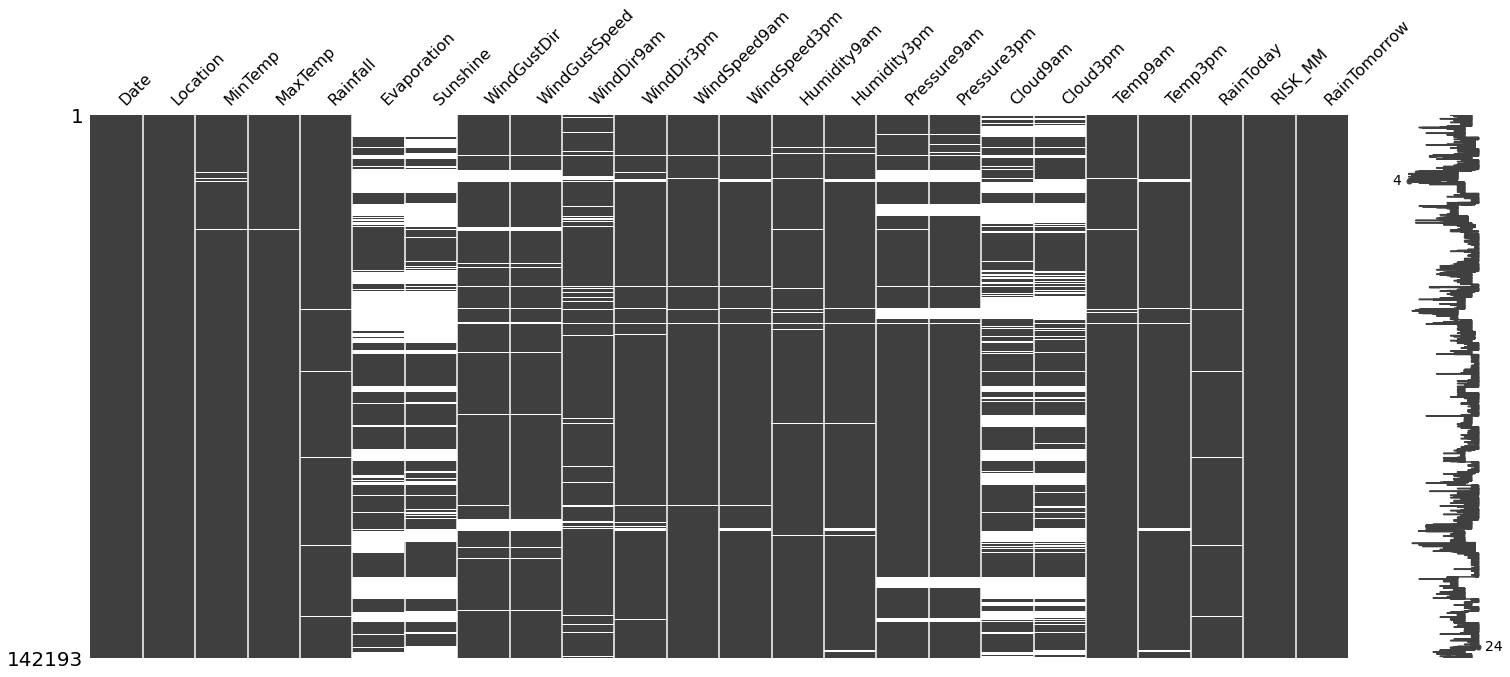

In [ ]:
msno.matrix(data)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [ ]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


## Tratando valores nulos

In [ ]:
#@title drop da coluna RISK_MM, como fala na descrição do dataset

data.drop(['RISK_MM'], axis=1, inplace=True)

In [ ]:
#@title median imputation nos dados numéricos faltantes

# colunas com dados numéricos
numerical = [col for col in data.columns if data[col].dtypes != 'O']
# imputação com mediana
for col in numerical:
    col_median=data[col].median()
    data[col].fillna(col_median, inplace=True)

In [ ]:
#@title most frequent imputation nos dados categóricos faltantes

# colunas com dados categóricos
categorical = [col for col in data.columns if data[col].dtypes == 'O']

# most frequent imputation
for col in categorical:
    data[col].fillna(data[col].mode()[0], inplace=True)

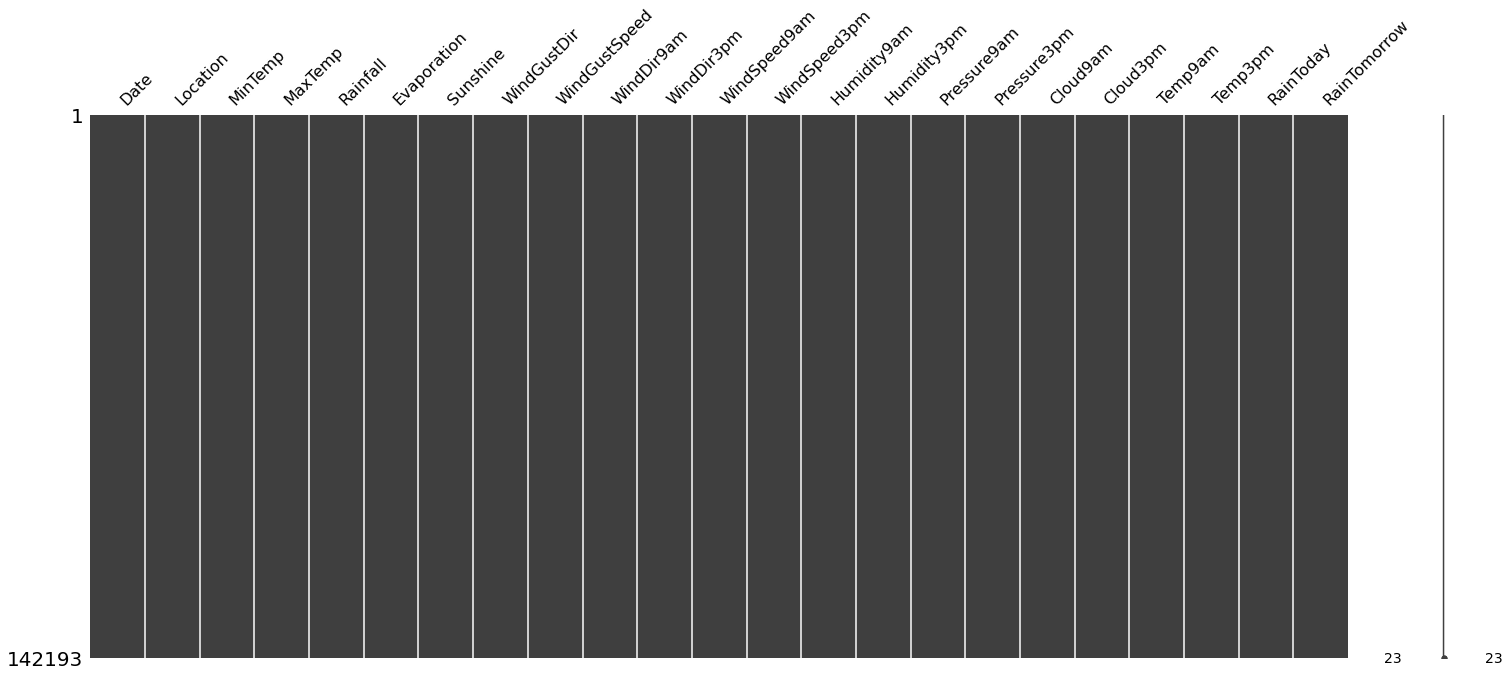

In [ ]:
#@title resultado
msno.matrix(data)

## Tratando outliers

In [ ]:
def max_value(df3, variable, top):
    return np.where(df3[variable]>top, top, df3[variable])


data['Rainfall'] = max_value(data, 'Rainfall', 3.2)
data['Evaporation'] = max_value(data, 'Evaporation', 21.8)
data['WindSpeed9am'] = max_value(data, 'WindSpeed9am', 55)
data['WindSpeed3pm'] = max_value(data, 'WindSpeed3pm', 57)

## Encoding variáveis categóricas

In [ ]:
# encode RainToday variable
encoder = ce.BinaryEncoder(cols=['RainToday'])

data = encoder.fit_transform(data)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
data = pd.concat([data[numerical], data[['RainToday_0', 'RainToday_1']],
                     pd.get_dummies(data.Location), 
                     pd.get_dummies(data.WindGustDir),
                     pd.get_dummies(data.WindDir9am),
                     pd.get_dummies(data.WindDir3pm),
                     data['RainTomorrow'].map({'No':0, 'Yes':1}).astype(int)], axis=1)

In [ ]:
data

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday_0,RainToday_1,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,...,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,RainTomorrow
0,13.4,22.9,0.6,4.8,8.5,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,7.4,25.1,0.0,4.8,8.5,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,12.9,25.7,0.0,4.8,8.5,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,9.2,28.0,0.0,4.8,8.5,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,4.8,8.5,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,3.5,21.8,0.0,4.8,8.5,31.0,15.0,13.0,59.0,27.0,1024.7,1021.2,5.0,5.0,9.4,20.9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
142189,2.8,23.4,0.0,4.8,8.5,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,5.0,5.0,10.1,22.4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
142190,3.6,25.3,0.0,4.8,8.5,22.0,13.0,9.0,56.0,21.0,1023.5,1019.1,5.0,5.0,10.9,24.5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
142191,5.4,26.9,0.0,4.8,8.5,37.0,9.0,9.0,53.0,24.0,1021.0,1016.8,5.0,5.0,12.5,26.1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Treinamento

In [ ]:
# 75/25 train test split
data_x = data.drop(['RainTomorrow'], axis=1)
data_y = data[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.25, random_state=42)

In [ ]:
# Instantiate a simple classification model
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(1, activation=tf.nn.sigmoid)
])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.BinaryCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1667/1667 [==============================] - 6s 3ms/step - loss: 1.1412 - binary_accuracy: 0.7732 - val_loss: 0.5346 - val_binary_accuracy: 0.8293
Epoch 2/30
1667/1667 [==============================] - 5s 3ms/step - loss: 0.5065 - binary_accuracy: 0.8066 - val_loss: 0.3867 - val_binary_accuracy: 0.8291
Epoch 3/30
1667/1667 [==============================] - 5s 3ms/step - loss: 0.4349 - binary_accuracy: 0.8214 - val_loss: 0.3611 - val_binary_accuracy: 0.8448
Epoch 4/30
1667/1667 [============

In [ ]:
model.predict(X_test)

array([[0.88153386],
       [0.3178805 ],
       [0.00851533],
       ...,
       [0.01612645],
       [0.68754995],
       [0.4883538 ]], dtype=float32)

## Melhorias

In [ ]:
# train, test, cv with 0.6, 0.2, 0.2 ratios

x, x_test, y, y_test = train_test_split(data_x, data_y, test_size=0.2, train_size=0.8)

x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.25, train_size =0.75)

In [ ]:
model.fit(x_train, y_train, validation_data=(x_cv, y_cv), epochs=30, batch_size=64)

Epoch 1/30
1334/1334 [==============================] - 5s 4ms/step - loss: 0.3477 - binary_accuracy: 0.8511 - val_loss: 0.3532 - val_binary_accuracy: 0.8500
Epoch 2/30
1334/1334 [==============================] - 4s 3ms/step - loss: 0.3482 - binary_accuracy: 0.8508 - val_loss: 0.3496 - val_binary_accuracy: 0.8499
Epoch 3/30
1334/1334 [==============================] - 4s 3ms/step - loss: 0.3477 - binary_accuracy: 0.8505 - val_loss: 0.3543 - val_binary_accuracy: 0.8463
Epoch 4/30
1334/1334 [==============================] - 4s 3ms/step - loss: 0.3469 - binary_accuracy: 0.8520 - val_loss: 0.3520 - val_binary_accuracy: 0.8493
Epoch 5/30
1334/1334 [==============================] - 4s 3ms/step - loss: 0.3477 - binary_accuracy: 0.8493 - val_loss: 0.3513 - val_binary_accuracy: 0.8486
Epoch 6/30
1334/1334 [==============================] - 4s 3ms/step - loss: 0.3470 - binary_accuracy: 0.8510 - val_loss: 0.3506 - val_binary_accuracy: 0.8498
Epoch 7/30
1334/1334 [==============================

In [ ]:
y_tested = y_test.to_numpy()
classes = y_pred > 0.5

In [ ]:
y_pred = model.predict(x_test)

m = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)
m.update_state(classes,y_tested)
m.result().numpy()


0.852421

## Regularização com L2


In [ ]:
# Instantiate a simple classification model
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),# Regulazer with L2
  layers.Dense(1, activation=tf.nn.sigmoid)
])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.BinaryCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

In [ ]:
model.fit(x_train, y_train, validation_data=(x_cv, y_cv), epochs=30, batch_size=64)

Epoch 1/30
1334/1334 [==============================] - 4s 3ms/step - loss: 0.3505 - binary_accuracy: 0.8495 - val_loss: 0.3619 - val_binary_accuracy: 0.8460
Epoch 2/30
1334/1334 [==============================] - 4s 3ms/step - loss: 0.3502 - binary_accuracy: 0.8500 - val_loss: 0.3568 - val_binary_accuracy: 0.8470
Epoch 3/30
1334/1334 [==============================] - 4s 3ms/step - loss: 0.3500 - binary_accuracy: 0.8505 - val_loss: 0.3556 - val_binary_accuracy: 0.8486
Epoch 4/30
1334/1334 [==============================] - 4s 3ms/step - loss: 0.3500 - binary_accuracy: 0.8504 - val_loss: 0.3566 - val_binary_accuracy: 0.8485
Epoch 5/30
1334/1334 [==============================] - 5s 4ms/step - loss: 0.3501 - binary_accuracy: 0.8506 - val_loss: 0.3545 - val_binary_accuracy: 0.8492
Epoch 6/30
1334/1334 [==============================] - 5s 3ms/step - loss: 0.3498 - binary_accuracy: 0.8512 - val_loss: 0.3551 - val_binary_accuracy: 0.8484
Epoch 7/30
1334/1334 [==============================

In [ ]:
y_tested = y_test.to_numpy()
classes = y_pred > 0.5

y_pred = model.predict(x_test)

m = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)
m.update_state(classes,y_tested)
m.result().numpy()


0.85090894